In [137]:
from glob import glob
from math import sqrt
import os

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Conv2DTranspose, Lambda, Reshape, Flatten, Dense, BatchNormalization
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.models import Model, load_model
import tensorflow.python.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [138]:
# Dataset preprocessing
# Only needs to be run once, Tyler ran it already

# DATA_DIR = "/hdd/datasets/UTKFace"
# image_paths = glob(DATA_DIR + "/*")

# images = np.zeros((len(image_paths), 96, 96, 3), dtype=np.float32)
# for i, image_path in enumerate(image_paths):
#     image = Image.open(image_path)
#     image = image.resize((96, 96), Image.LANCZOS)
#     images[i] = np.array(image) / 255.
# np.save("/hdd/datasets/UTKFace.npy", images)

In [139]:
# Loads numpy file containing dataset
images = np.load("/hdd/datasets/UTKFace.npy")

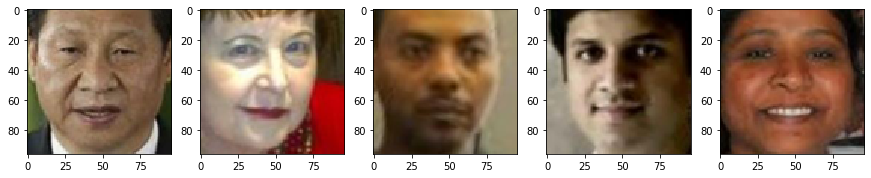

In [140]:
# Plots some sample images
fig, ax = plt.subplots(ncols=5, figsize=(15, 15))
for i, col in enumerate(ax):
    col.imshow(images[i])

In [166]:
def create_encoder(input_shape, encoding_dim):
    if not sqrt(encoding_dim).is_integer():
        raise ValueError("Encoding dim must be a perfect square.")

    inputs = Input(shape=input_shape)
    conv1 = Conv2D(16, 3, padding="same", activation="relu")(inputs)
    conv1 = Conv2D(16, 3, padding="same", activation="relu")(conv1)
    norm1 = BatchNormalization()(conv1)
    pool1 = MaxPool2D()(norm1)
    
    conv2 = Conv2D(32, 3, padding="same", activation="relu")(pool1)
    conv2 = Conv2D(32, 3, padding="same", activation="relu")(conv2)
    norm2 = BatchNormalization()(conv2)
    pool2 = MaxPool2D()(norm2)
    
    conv3 = Conv2D(64, 3, padding="same", activation="relu")(pool2)
    conv3 = Conv2D(64, 3, padding="same", activation="relu")(conv3)
    norm3 = BatchNormalization()(conv3)
    pool3 = MaxPool2D()(norm3)
    
    conv4 = Conv2D(128, 3, padding="same", activation="relu")(pool3)
    conv4 = Conv2D(128, 3, padding="same", activation="relu")(conv4)
    norm4 = BatchNormalization()(conv4)
    pool4 = MaxPool2D()(norm4)
    
    conv5 = Conv2D(128, 1, padding="same", activation="relu")(pool4)
    
    assert conv5.shape[1] == int(sqrt(encoding_dim))
    
    encoder = Model(inputs, conv5)
    encoder.summary()
    
    return encoder

In [167]:
def create_decoder(encoding_dim):
    if not sqrt(encoding_dim).is_integer():
        raise ValueError("Encoding dim must be a perfect square.")
        
    inputs = Input(shape=(int(sqrt(encoding_dim)), int(sqrt(encoding_dim)), 128))
    conv1 = Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(inputs)
    conv2 = Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(conv1)
    conv3 = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(conv2)
    conv4 = Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(conv3)
    conv5 = Conv2D(3, 3, padding="same", activation="sigmoid")(conv4)
    
    decoder = Model(inputs, conv5)
    decoder.summary()
    
    return decoder

In [168]:
input_shape = images[0].shape
ENCODING_DIM = 36

In [169]:
encoder = create_encoder(input_shape, ENCODING_DIM)
decoder = create_decoder(ENCODING_DIM)

inputs = Input(shape=input_shape)
encoded = encoder(inputs)
decoded = decoder(encoded)

autoencoder = Model(inputs, decoded)
autoencoder.summary()

autoencoder.compile(optimizer="adam", loss="mse")

Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 96, 96, 16)        448       
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 96, 96, 16)        2320      
_________________________________________________________________
batch_normalization_70 (Batc (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 48, 48, 32)        4640      
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 48, 48, 32)        924

In [170]:
!mkdir -p models/ae
checkpointer = ModelCheckpoint("models/ae/epoch{epoch}_loss{val_loss:.4f}.h5", save_best_only=True, verbose=1)
autoencoder.fit(images, images, batch_size=128, epochs=50, validation_split=0.2, callbacks=[checkpointer])

Train on 18966 samples, validate on 4742 samples
Epoch 1/50
18944/18966 [============================>.] - ETA: 0s - loss: 0.0205
Epoch 00001: val_loss improved from inf to 0.03312, saving model to models/ae/epoch1_loss0.0331.h5
18966/18966 [==============================] - 18s 967us/sample - loss: 0.0205 - val_loss: 0.0331
Epoch 2/50
18944/18966 [============================>.] - ETA: 0s - loss: 0.0061
Epoch 00002: val_loss improved from 0.03312 to 0.01510, saving model to models/ae/epoch2_loss0.0151.h5
18966/18966 [==============================] - 11s 589us/sample - loss: 0.0061 - val_loss: 0.0151
Epoch 3/50
18944/18966 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 00003: val_loss improved from 0.01510 to 0.00579, saving model to models/ae/epoch3_loss0.0058.h5
18966/18966 [==============================] - 11s 579us/sample - loss: 0.0048 - val_loss: 0.0058
Epoch 4/50
18944/18966 [============================>.] - ETA: 0s - loss: 0.0042
Epoch 00004: val_loss improv

KeyboardInterrupt: 

In [171]:
saved_models = sorted(glob("models/ae/*"), key=os.path.getmtime)
autoencoder = load_model(saved_models[-1])
encoder = autoencoder.get_layer(index=1)
decoder = autoencoder.get_layer(index=2)

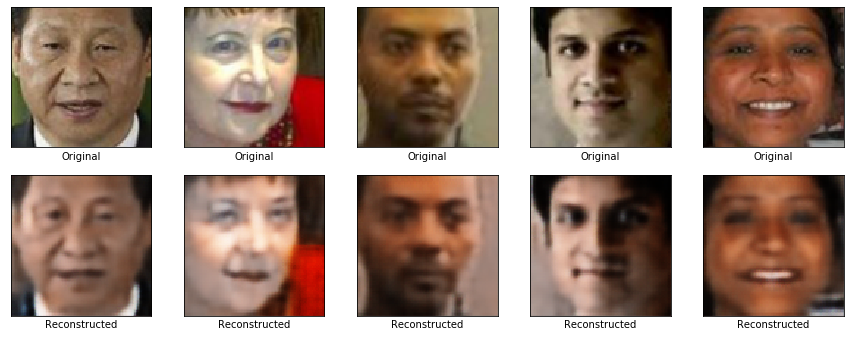

In [172]:
visual = images[:5]
preds = autoencoder.predict(visual)

plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(visual[i])
    plt.xlabel("Original")
for i in range(5):
    plt.subplot(5,5,i+6)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i])
    plt.xlabel("Reconstructed")
plt.show()

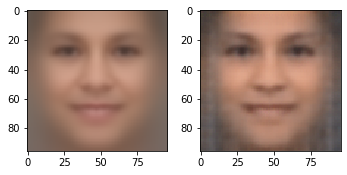

In [194]:
plt.figure(figsize=(15, 15))

plt.subplot(5, 5, 1)
preds = autoencoder.predict(images)
avg = np.mean(images, axis=0)
plt.imshow(avg)

plt.subplot(5, 5, 2)
latent = encoder.predict(images)
avg = np.expand_dims(np.mean(latent, axis=0), 0)
pred = decoder.predict(avg).squeeze()
plt.imshow(pred)

In [173]:
def create_variational_encoder(input_shape, encoding_dim):
    if not sqrt(encoding_dim).is_integer():
        raise ValueError("Encoding dim must be a perfect square.")

    inputs = Input(shape=input_shape)
    conv1 = Conv2D(16, 3, padding="same", activation="relu")(inputs)
    conv1 = Conv2D(16, 3, padding="same", activation="relu")(conv1)
    norm1 = BatchNormalization()(conv1)
    pool1 = MaxPool2D()(norm1)
    
    conv2 = Conv2D(32, 3, padding="same", activation="relu")(pool1)
    conv2 = Conv2D(32, 3, padding="same", activation="relu")(conv2)
    norm2 = BatchNormalization()(conv2)
    pool2 = MaxPool2D()(norm2)
    
    conv3 = Conv2D(64, 3, padding="same", activation="relu")(pool2)
    conv3 = Conv2D(64, 3, padding="same", activation="relu")(conv3)
    norm3 = BatchNormalization()(conv3)
    pool3 = MaxPool2D()(norm3)
    
    conv4 = Conv2D(128, 3, padding="same", activation="relu")(pool3)
    conv4 = Conv2D(128, 3, padding="same", activation="relu")(conv4)
    norm4 = BatchNormalization()(conv4)
    pool4 = MaxPool2D()(norm4)
    
    conv5 = tfp.layers.Convolution2DFlipout(128, 1, padding="same")(pool4)
    
    assert conv5.shape[1] == int(sqrt(encoding_dim))
    
    encoder = Model(inputs, conv5)
    encoder.summary()
    
    return encoder

In [174]:
def create_variational_decoder(encoding_dim):
    if not sqrt(encoding_dim).is_integer():
        raise ValueError("Encoding dim must be a perfect square.")
        
    inputs = Input(shape=(int(sqrt(encoding_dim)), int(sqrt(encoding_dim)), 128))
    conv1 = Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(inputs)
    conv2 = Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(conv1)
    conv3 = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(conv2)
    conv4 = Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(conv3)
    conv5 = Conv2D(3, 3, padding="same", activation="sigmoid")(conv4)
    
    decoder = Model(inputs, conv5)
    decoder.summary()
    
    return decoder

In [175]:
variational_encoder = create_variational_encoder(input_shape, ENCODING_DIM)
variational_decoder = create_variational_decoder(ENCODING_DIM)

variational_inputs = Input(shape=input_shape)
variational_encoded = variational_encoder(variational_inputs)
variational_decoded = variational_decoder(variational_encoded)

variational_autoencoder = Model(variational_inputs, variational_decoded)
variational_autoencoder.summary()

Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 96, 96, 16)        448       
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 96, 96, 16)        2320      
_________________________________________________________________
batch_normalization_74 (Batc (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 48, 48, 32)        4640      
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 48, 48, 32)        924

In [176]:
def create_loss_fn(model, batch_size, dataset_size):
    kl = (BATCH_SIZE / dataset_size) * sum(model.losses) 

    def loss_fn(y_true, y_pred):
        bce = tf.keras.losses.BinaryCrossentropy()
        nll = bce(y_true, y_pred)
        return nll + kl
    
    return loss_fn

variational_autoencoder.compile(optimizer="adam", loss=create_loss_fn(variational_autoencoder, BATCH_SIZE, images.shape[0]))

In [206]:
!mkdir -p models/vae
checkpointer = ModelCheckpoint("models/vae/epoch{epoch}_loss{val_loss:.0f}.h5", save_best_only=True, verbose=1)
variational_autoencoder.fit(images, images, batch_size=BATCH_SIZE, epochs=100, validation_split=0.2, callbacks=[checkpointer])

Train on 18966 samples, validate on 4742 samples
Epoch 1/100
18944/18966 [============================>.] - ETA: 0s - loss: 0.5726
Epoch 00001: val_loss improved from inf to 0.57431, saving model to models/vae/epoch1_loss1.h5
18966/18966 [==============================] - 12s 612us/sample - loss: 0.5726 - val_loss: 0.5743
Epoch 2/100
18944/18966 [============================>.] - ETA: 0s - loss: 0.5722
Epoch 00002: val_loss improved from 0.57431 to 0.57217, saving model to models/vae/epoch2_loss1.h5
18966/18966 [==============================] - 12s 617us/sample - loss: 0.5721 - val_loss: 0.5722
Epoch 3/100
18944/18966 [============================>.] - ETA: 0s - loss: 0.5722
Epoch 00003: val_loss did not improve from 0.57217
18966/18966 [==============================] - 12s 607us/sample - loss: 0.5722 - val_loss: 0.5738
Epoch 4/100
18944/18966 [============================>.] - ETA: 0s - loss: 0.5721
Epoch 00004: val_loss did not improve from 0.57217
18966/18966 [====================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [213]:
saved_models = sorted(glob("models/vae/*"), key=os.path.getmtime)
variational_autoencoder = load_model(saved_models[-1], custom_objects={"Conv2DFlipout": tfp.layers.Convolution2DFlipout(128, 1, padding="same")})
variational_encoder = autoencoder.get_layer(index=1)
variational_decoder = autoencoder.get_layer(index=2)

TypeError: 'str' object is not callable

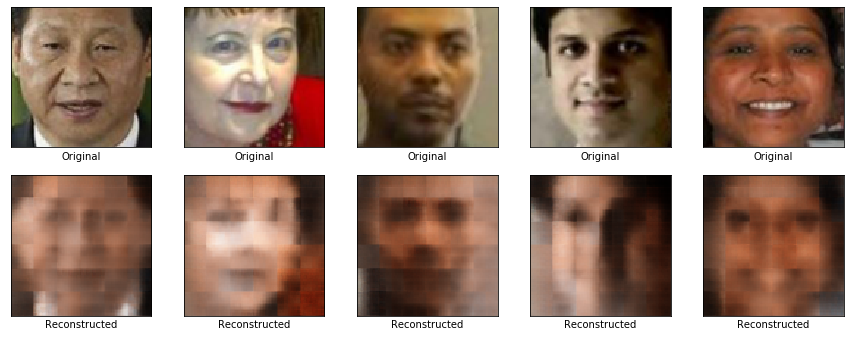

In [208]:
visual = images[:5]

preds = np.zeros((25, 5, 96, 96, 3))
for i in range(0, 25):
    preds[i] = variational_autoencoder.predict(visual)
preds = preds.mean(axis=0)

plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(visual[i])
    plt.xlabel("Original")
for i in range(5):
    plt.subplot(5,5,i+6)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i])
    plt.xlabel("Reconstructed")
plt.show()

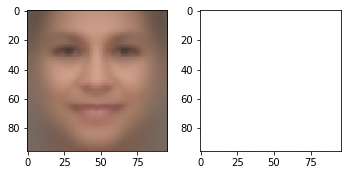

In [210]:
plt.figure(figsize=(15, 15))

plt.subplot(5, 5, 1)
preds = variational_autoencoder.predict(images)
avg = np.mean(images, axis=0)
plt.imshow(avg)

plt.subplot(5, 5, 2)
latent = variational_encoder.predict(images)
avg = np.expand_dims(np.mean(latent, axis=0), 0)
pred = variational_decoder.predict(avg).squeeze()
plt.imshow(pred)